# Решение задачи предсказания рейтинга шоколада

Никнейм на Kaggle: `geparrrd`.

Ссылка на соревнование: https://www.kaggle.com/competitions/practical-ml-chocolate/overview

## Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"
RANDOM_STATE = 313

In [4]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [ ]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Очевидно, что процентное содержание какао необходимо преобразовать в численный тип данных

In [ ]:
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].map(lambda x: float(x[:-1]))

Получаем первичную информацию о данных

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   float64
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 88.4+ KB


Всего по одному пропуску в двух фичах, поэтому можем смело удалить соответствующие строки

In [ ]:
train_df.dropna(subset=['Bean Type', 'Broad Bean Origin'], inplace=True)

Смотрим статистику признаков и целевой переменной

In [ ]:
train_df.describe()

,REF,Review,Cocoa Percent,Rating
count,1253.000000,1253.000000,1253.000000,1253.000000
mean,1045.483639,2012.383879,71.791700,3.176377
std,551.624106,2.924551,6.402353,0.478383
min,5.000000,2006.000000,46.000000,1.000000
25%,593.000000,2010.000000,70.000000,2.750000
50%,1081.000000,2013.000000,70.000000,3.250000
75%,1514.000000,2015.000000,75.000000,3.500000
max,1952.000000,2017.000000,100.000000,5.000000


In [ ]:
train_df.describe(include='object')

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
count,1253,1253,1253,1253,1253
unique,376,761,58,38,83
top,Soma,Madagascar,U.S.A.,,Venezuela
freq,34,38,520,628,144


Категориальные признаки имеют большое число уникальных значений (> 30), значит применение `OneHot`-кодирования неразумно. Также 100%-е содержание какао выглядит подозрительно, что говорит о вероятном выбросе.

Рассмотрим категориальные признаки подробнее на предмет пропущенных значений (пробелов, не NaN).

In [ ]:
train_df['Broad Bean Origin'].sort_values().unique()

array(['Australia', 'Belize', 'Bolivia', 'Brazil', 'Carribean',
       'Carribean(DR/Jam/Tri)', 'Central and S. America', 'Colombia',
       'Colombia, Ecuador', 'Congo', 'Cost Rica, Ven', 'Costa Rica',
       'Cuba', 'DR, Ecuador, Peru', 'Dom. Rep., Madagascar',
       'Domincan Republic', 'Dominican Rep., Bali', 'Dominican Republic',
       'Ecuador', 'El Salvador', 'Fiji', 'Gabon', 'Ghana',
       'Ghana, Domin. Rep', 'Grenada', 'Guat., D.R., Peru, Mad., PNG',
       'Guatemala', 'Haiti', 'Hawaii', 'Honduras', 'India', 'Indonesia',
       'Indonesia, Ghana', 'Ivory Coast', 'Jamaica', 'Liberia',
       'Mad., Java, PNG', 'Madagascar', 'Madagascar & Ecuador',
       'Malaysia', 'Mexico', 'Nicaragua', 'Nigeria', 'PNG, Vanuatu, Mad',
       'Panama', 'Papua New Guinea', 'Peru', 'Peru, Belize',
       'Peru, Dom. Rep', 'Peru, Ecuador, Venezuela',
       'Peru, Mad., Dom. Rep.', 'Peru, Madagascar', 'Philippines',
       'Principe', 'Puerto Rico', 'Samoa', 'Sao Tome',
       'Sao Tome & Pr

Видим, что есть символ `\xa0`, обозначающий неразрывный пробел, а значит пропуск. Посмотрим, сколько их.

In [ ]:
train_df[train_df['Broad Bean Origin'] == '\xa0'].shape

(55, 9)

Всего `52` пропуска. Относительно объёма данных это не много (`~ 4%`), но и не так мало, чтобы можно было смело удалить строки. Заменим их на часто встречающуюся категорию.

In [ ]:
train_df['Broad Bean Origin'] = train_df['Broad Bean Origin'].replace('\xa0', train_df['Broad Bean Origin'].mode()[0])

Продолжим смотреть пропуски

In [ ]:
train_df['Bean Type'].sort_values().unique()

array(['Amazon', 'Amazon mix', 'Amazon, ICS', 'Blend',
       'Blend-Forastero,Criollo', 'Criollo', 'Criollo (Amarru)',
       'Criollo (Ocumare 61)', 'Criollo (Ocumare 67)',
       'Criollo (Ocumare 77)', 'Criollo (Ocumare)', 'Criollo (Porcelana)',
       'Criollo (Wild)', 'Criollo, +', 'Criollo, Forastero',
       'Criollo, Trinitario', 'EET', 'Forastero', 'Forastero (Amelonado)',
       'Forastero (Arriba)', 'Forastero (Arriba) ASS',
       'Forastero (Arriba) ASSS', 'Forastero (Catongo)',
       'Forastero (Nacional)', 'Forastero (Parazinho)',
       'Forastero(Arriba, CCN)', 'Forastero, Trinitario', 'Matina',
       'Nacional', 'Nacional (Arriba)', 'Trinitario',
       'Trinitario (85% Criollo)', 'Trinitario (Amelonado)',
       'Trinitario, Criollo', 'Trinitario, Forastero',
       'Trinitario, Nacional', 'Trinitario, TCGA', '\xa0'], dtype=object)

In [ ]:
train_df[train_df['Bean Type'] == '\xa0'].shape

(628, 9)

У признака `Bean Type` половина датасета составляют пропущенные значения. Этот столбец можно было бы удалить, но предварительные тесты показали, что этот признак является очень важным, поэтому оставим его, а пропуски будут приняты в качестве дополнительной категории.

In [ ]:
train_df['Company'].sort_values().unique()

array(['A. Morin', 'AMMA', 'Adi', 'Aequare (Gianduja)', 'Ah Cacao',
       "Akesson's (Pralus)", 'Alain Ducasse', 'Alexandre',
       'Altus aka Cao Artisan', 'Amano', 'Amatller (Simon Coll)',
       'Amazona', 'Ambrosia', 'Amedei', 'Animas', 'Ara', 'Arete',
       'Artisan du Chocolat', 'Askinosie', 'Bahen & Co.', 'Bakau',
       'Bar Au Chocolat', "Baravelli's", 'Batch', 'Beau Cacao', 'Beehive',
       'Belcolade', 'Bellflower', 'Belyzium', 'Benoit Nihant',
       'Bernachon', 'Beschle (Felchlin)', 'Bisou', 'Bittersweet Origins',
       'Black Mountain', 'Black River (A. Morin)', 'Blanxart',
       'Blue Bandana', 'Bonnat', 'Bouga Cacao (Tulicorp)', 'Bowler Man',
       "Brasstown aka It's Chocolate", 'Brazen', 'Breeze Mill', 'Bright',
       'Britarev', 'Bronx Grrl Chocolate', 'Burnt Fork Bend', 'C-Amaro',
       'Cacao Arabuco', 'Cacao Atlanta', 'Cacao Barry', 'Cacao Hunters',
       'Cacao Prieto', 'Cacao Sampaka', 'Cacao de Origen',
       'Cacao de Origin', 'Cacaoyere (Ecuatoria

In [ ]:
train_df['Company Location'].sort_values().unique()

array(['Amsterdam', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Czech Republic', 'Denmark', 'Domincan Republic', 'Ecuador',
       'Eucador', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana',
       'Grenada', 'Guatemala', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Madagascar',
       'Mexico', 'Netherlands', 'New Zealand', 'Niacragua', 'Nicaragua',
       'Peru', 'Poland', 'Portugal', 'Puerto Rico', 'Russia', 'Sao Tome',
       'Scotland', 'Singapore', 'South Africa', 'South Korea', 'Spain',
       'St. Lucia', 'Suriname', 'Sweden', 'Switzerland', 'U.K.', 'U.S.A.',
       'Venezuela', 'Vietnam', 'Wales'], dtype=object)

In [ ]:
train_df['Specific Bean Origin'].sort_values().unique()

array(['"heirloom", Arriba Nacional', '100 percent', '2009 Hapa Nibby',
       'A case of the Xerces Blues, triple roast',
       'Abstract S. w/ Jamaica nibs,batch abs60323.0',
       'Acarigua, w/ nibs', 'Acul-du-Nord, 2015', 'Africa',
       'Africa meets Latina', 'Agua Fria; Sucre region', 'Agua Grande',
       'Akata', 'Akesson Estate', 'Akesson P.',
       "Akesson's E., Sambirano V.", "Akesson's Estate",
       "Akesson's, batch 4411", 'Akessons Estate, Sambirano, 2013',
       'Akessons Estate, Sambirano, Ambanja', 'Akosombo',
       'Alta Verapaz, 2014', 'Alto Beni', 'Alto Beni, Covendo Region',
       'Alto Beni, Cru Savage', 'Alto Beni, Palos Blanco',
       'Alto Beni, Palos Blancos', 'Alto Beni, Upper Rio Beni, 2014',
       'Alto Beni, Wild Bolivian',
       'Alto Beni, Wild Harvest, Itenez R. 24hr c.',
       'Alto Beni, Wild Harvest, Itenez R., 60hr c.',
       'Alto Beni, Wild Harvest, Limited Ed.', 'Amazonas',
       'Amazonas w/ nibs', 'Amazonia', 'Ambanja, Sambirano

У остальных признаков пропуски не обнаружены.

Таким образом, мы конвертировали признак `Cocoa Percent` в числовой тип данных, удалили пару строк со значениями `NaN`, преобразовали пропуски в виде пробелов в признаке `Broad Bean Origin` и оставили признак `Bean Type`, содержащий половину строк с пробелами.

## Анализ выбросов, построение распределений признаков

Выделяем матрицу объект-признак и вектор с целевой переменной

In [ ]:
X_train = train_df.drop('Rating', axis=1)
y_train = train_df['Rating']

Выделяем числовые и категориальные столбцы

In [ ]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']
print('Числовые признаки: ', num_cols)
print('Категориальные признаки: ', cat_cols)

Числовые признаки:  ['REF', 'Review', 'Cocoa Percent']
Категориальные признаки:  ['Company', 'Specific Bean Origin', 'Company Location', 'Bean Type', 'Broad Bean Origin']


Посмотрим распределение числовых признаков

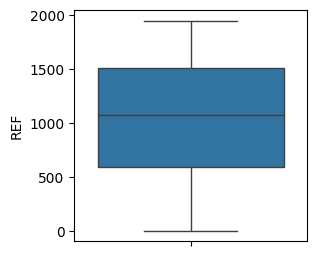

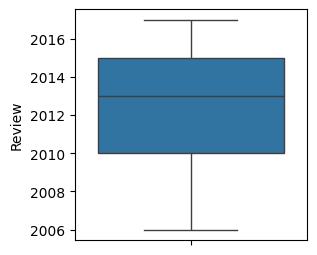

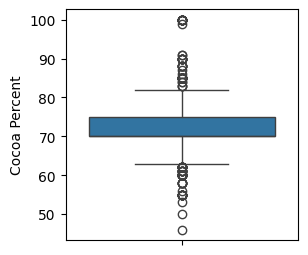

In [ ]:
for col in num_cols:
    plt.figure(figsize=(3, 3))
    sns.boxplot(data=X_train[col])
    plt.show()

В глаза бросаются значения `Cocoa Percent` около 100. Это похоже на выбросы, так как в реальности вряд ли возможен шоколад со 100-процентным содержанием какао. Удалим эти данные.

In [ ]:
X_train = X_train[X_train['Cocoa Percent'] < 95]

In [ ]:
y_train = y_train[X_train.index]

Посмотрим на распределение целевой переменной.

<Axes: ylabel='Rating'>

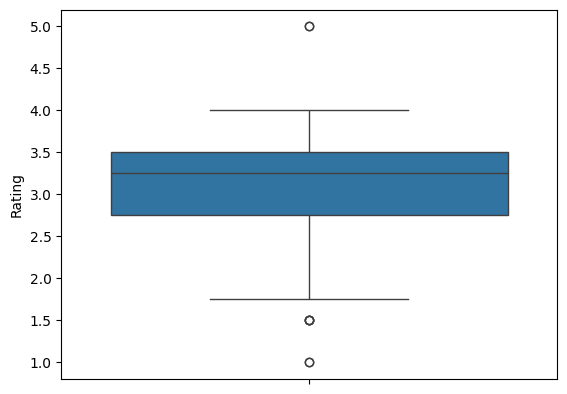

In [ ]:
sns.boxplot(y_train)

Достаточно далеко от общей массы значений находятся значения рейтинга 1 и 5. Предварительные тесты с моделью `CatBoostRegressor` показали, что наилучший результат обучения (оценка `r2-score`) достигается при удалении рейтинга 1. Удалим его.

In [ ]:
y_train = y_train[y_train > 1]

In [ ]:
X_train = X_train.loc[y_train.index, :]

Построим матрицу корреляций числовых признаков.

<Axes: >

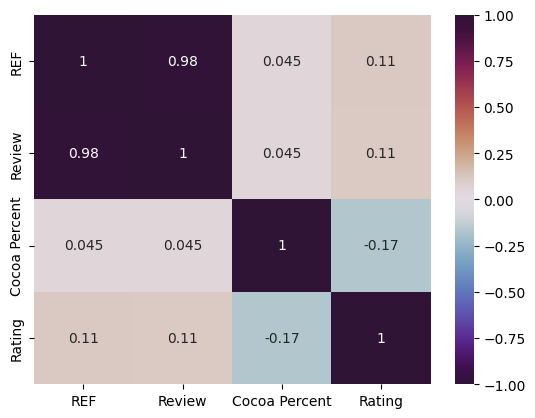

In [ ]:
temp_df = train_df[num_cols + ['Rating']]

sns.heatmap(data=temp_df.corr(), cmap='twilight_shifted', annot=True, vmin=-1, vmax=1)

Наблюдается сильная корреляция между признаками `REF` и `Review`. В данном случае, можно оставить как есть, а также удалить один из коррелированных признаков, либо перемножить их с удалением исходных. Прогнозы с помощью `CatBoost` со встроенной кодировкой показали, что лучший результат достигается, если оставить признаки как есть.

Посмотрим корреляцию между категориальными признаками

In [ ]:
!pip install association-metrics

  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3930 sha256=cf39683b6166000d48dcc31e7efe9a527b87aeb151f13b43928ffe6f6322cef4
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


<Axes: >

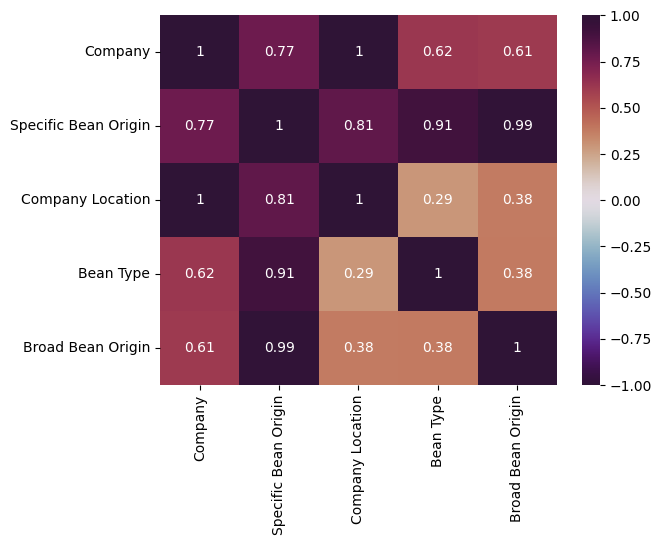

In [ ]:
import association_metrics as am

XC = X_train.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

matrix_Cram = cramersv.fit()

sns.heatmap(data=matrix_Cram, cmap='twilight_shifted', annot=True, vmin=-1, vmax=1)

Сильная корреляция между `Company` и `Company Location`, между `Specific Bean Origin` и `Broad Bean Origin`. Предварительные тесты показали, что лучше удалить только признак `Company Location`.

In [ ]:
X_train.drop(['Company Location'], axis=1, inplace=True)

Вывод:
Были удалены строки со значением процентного содержания какао (`Cocoa Percent`) более 95%, удалены строки с рейтингом (`Rating`) 1. Удалён признак `Company Location` из-за сильной корреляции с признаком `Company`, а также исходя из результатов обучения с помощью `CatBoostRegressor` со встроенной кодировкой.

## Построение новых признаков, обоснование

Построим новые признаки на основе устоявшихся.

Общий принцип построения признаков на основе категориальных, принятый в данной работе - посчитать количество категорий встречающихся в признаке для каждой категории и связать это количество с категорией. Таким образом признак будет отражать частоту, с которой встречается та или иная категория. Затем смотрим распределение нового признака и строим на его основе ещё один категориальный, группирующий значения числового признака.

Принцип построения признаков на основе числовых - перемножение исходных до `2`-го порядка включительно.

Отбор признаков осуществлён на основе результатов обучения модели `CatBoostRegressor` со встроенной кодировкой категорильных признаков с использованием метрики `r2-score`. Обучение проводилось как на одной части тренировчной выборки с предсказанием на другой, так и при кросс-валидации с `5`-ю фолдами. Дополнительно оценивается стандартное отклонение метрик при кросс-валидации. Также признаки отбирались исходя из результата прогноза на тестовых данных при их публикации на `Kaggle`.

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

Построим функцию для получения значений метрик для заданной выборки и функцию для получения матрицы корреляции числовых признаков.

In [ ]:
def get_scores(X, y):
    X_train_new, X_val, y_train_new, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    cat_cols = [col for col in X.columns if X[col].dtype == 'object']

    reg_cat = CatBoostRegressor(cat_features=cat_cols, verbose=0, random_state=RANDOM_STATE)

    reg_cat.fit(X_train_new, y_train_new)
    y_pred = reg_cat.predict(X_val)
    r2 = r2_score(y_val, y_pred)

    scores = cross_val_score(reg_cat, X, y, cv=5, scoring='r2')
    print('r2 на одном фолде:', r2, '\nСредний r2:', scores.mean(), '\nSTD r2:', scores.std())


def get_num_corr(X, y):
    num_cols_temp = [col for col in X.columns if X[col].dtype != 'object']
    temp_df = X[num_cols_temp]
    temp_df['Rating'] = y

    return sns.heatmap(data=temp_df.corr(), cmap='twilight_shifted', annot=True, vmin=-1, vmax=1)

Посмотрим значения метрик

In [ ]:
get_scores(X_train, y_train)

r2 на одном фолде: 0.20266208901711402 
Средний r2: 0.16632922128071714 
STD r2: 0.057207020465132444


Базовый результат: на одном фолде `0.203`, средний `0.166`, STD `0.057`.


Новые признаки на основе категориальных строились с помощью конструкций `groupby` и `transform`. Построим первый.

In [ ]:
X_train['Bean Type_freq'] = X_train.groupby('Bean Type')['Bean Type'].transform('count')

In [ ]:
get_scores(X_train, y_train)

r2 на одном фолде: 0.29427935700581775 
Средний r2: 0.21989594622847447 
STD r2: 0.07408865229901902


Результат улучшился!

Посмотрим распределение этого признака

array([[<Axes: title={'center': 'Bean Type_freq'}>]], dtype=object)

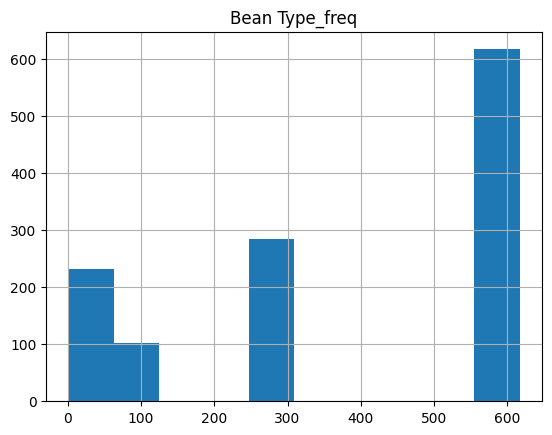

In [ ]:
X_train[['Bean Type_freq']].hist()

Видим, что есть три чёткие группы, на которые можно разделить признак, условно на редкий тип какао-бобов, средний и популярный. Последний является категорией-пробелом, как было показано выше. Однако, всё же примем его за отдельную категорию.

Создадим функцию для обозначения редкости какао-бобов в зависимости от количества категорий.

In [ ]:
#  Редкость типов бобов в зависимости от их количества в датасете
def rarity(value):
    if value < 200:
        return 'rare'
    elif value < 400:
        return 'medium'
    return 'famous'

In [ ]:
X_train['Bean_Type_Rarity'] = X_train['Bean Type_freq'].apply(rarity)

In [ ]:
X_train.drop('Bean Type_freq', axis=1, inplace=True)

In [ ]:
get_scores(X_train, y_train)

r2 на одном фолде: 0.2813310948620785 
Средний r2: 0.21760782350038538 
STD r2: 0.08393568732195311


Значения `r2-score` снизились, однако `стандартное отклонение` по кросс-валидации также значительно снизилось, что говорит о снижении переобучения модели. Результат на тестовых данных оказался гораздо выше, поэтому этот признак оставляем.

Аналогичным образом можно создать признаки на основе других категориальных признаков, однако они не показали себя лучше, чем на данный момент. При текущем наборе признаков значение `r2-score` на тестовых данных при обучении модели `CatBoostRegressor` со встроенной кодировкой и параметрами по умолчанию - `0.19053`.

Например, посмотрим на распределение признака на основе признака `Company`.

In [ ]:
X_train['Company_freq'] = X_train.groupby('Company')['Company'].transform('count')

array([[<Axes: title={'center': 'Company_freq'}>]], dtype=object)

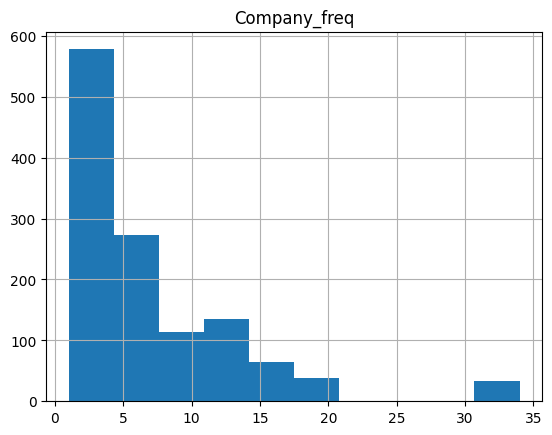

In [ ]:
X_train[['Company_freq']].hist()

Видим, что есть большое количество компаний, которые редко встречаются в данных. На основе этого признака можно было бы создать признак, условно обозначающий известность компании - этот признак, исходя из общих соображений, вполне мог бы отражаться на рейтинге шоколада. Например, можно подобрать границу, разделяющую график на две части, обозначающие известные компании и малоизвестные. Однако эти признаки с перебором всевозможных положений границы не улучшают результаты прогноза на тестовых данных.

Посмотрим для примера результаты обучения на тренировчной выборке и матрицу корреляций.

In [ ]:
get_scores(X_train, y_train)

r2 на одном фолде: 0.1967480797505914 
Средний r2: 0.16348385562731066 
STD r2: 0.04747196333160441


Результат слегка ухудшился по сравнению с предыдщим результатом: `r2-score` снизился, `STD` увеличилось.

<ipython-input-32-0c1149415d42>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Rating'] = y


<Axes: >

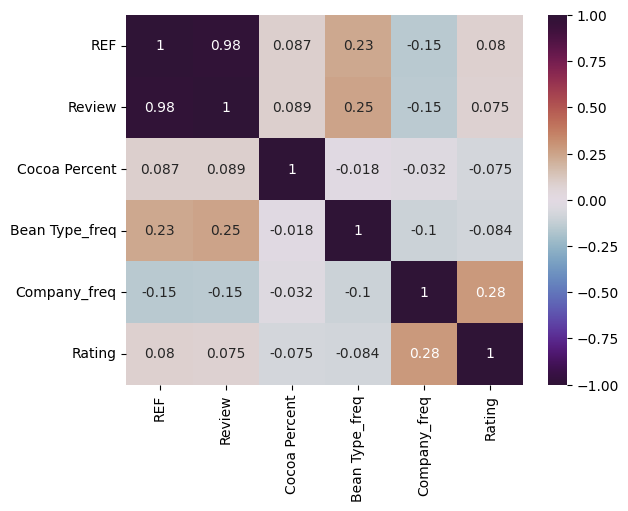

In [ ]:
get_num_corr(X_train, y_train)

Новый признак `Company_freq` имеет наибольшую корреляцию с целевой переменной. Тем не менее, он оказывается не значительным.

Удалим его.

In [ ]:
X_train.drop('Company_freq', axis=1, inplace=True)

Новые признаки на основе числовых были построены путём их перемножения. Некоторые новые признаки улучшали результаты прогноза на тренирочной выборке, однако ухудшали прогнозы на тестовой выборке. Поэтому новые признаки не были добавлены.

Ниже показны примеры новых признаков.

In [ ]:
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']
print('Числовые признаки: ', num_cols)

Числовые признаки:  ['REF', 'Review', 'Cocoa Percent', 'Bean Type_freq']


In [ ]:
# X_train['Bean_2'] = X_train['Bean Type_freq'] ** 2
# X_train['REF_Bean'] = X_train['REF'] * X_train['Bean Type_freq']
# X_train['Cocoa_Bean'] = X_train['Cocoa Percent'] * X_train['Bean Type_freq']
# X_train['Review_Cocoa'] = X_train['Review'] * X_train['Cocoa Percent']
# X_train['Review_Bean'] = X_train['Review'] * X_train['Bean Type_freq']

Посмотрим на важность признаков для модели `CatBoostRegressor`.

In [ ]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
model = CatBoostRegressor(cat_features=cat_cols, verbose=0)

model.fit(X_train, y_train)
pd.DataFrame({'feature_name': model.feature_names_,
              'importance': model.get_feature_importance()}).sort_values(by='importance', ascending=False)

,feature_name,importance
0,Company,26.808447
6,Broad Bean Origin,15.327817
2,REF,14.190960
4,Cocoa Percent,13.434674
8,Bean_Type_Rarity,9.059101
5,Bean Type,8.495514
1,Specific Bean Origin,7.444779
3,Review,3.460836
7,Bean Type_freq,1.777871


Видим, что новый признак `Bean Type_freq` имеет наименьшее влияние на модель, однако его удаление привело бы к ухудшению результатов.

Вывод:
Были обосновано добавлены два новых признака на основе признака `Bean Type`: `Bean Type_freq` и `Bean_Type_Rarity`.

## Построение Pipeline

Посмотрим на результаты обучения других моделей с использованием кодировщиков и масштабирования.

План

1. Для кодирования категориальных признаков будем использовать `Target Encoding` и `Ordinal Encoding` (из-за большого числа уникальных значений).
2. Для масштабирования признаков используем `StandardScaler` и `MinMaxScaler`.
3. Рассмотрим пайплайны с построением новых признаков с помощью `PolynomialsFeatures` и без.
4. Используем линеную модель, случайный лес и бустинг `XGBoost`.

In [ ]:
!pip install category_encoders -q
!pip install xgboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

Напишем функцию для построения `Pipeline` в зависимости от применяемых шагов и функцию получения среднего значения метрики `r2` для заданного пайплайна.

In [ ]:
def make_pipeline(enc, scaler, model, make_features=False):
    if make_features:
        my_pipeline = Pipeline([
            ('encoder', enc),
            ('features', PolynomialFeatures()),
            ('scaler', scaler),
            ('model', model)
            ])
    else:
        my_pipeline = Pipeline([
              ('encoder', enc),
              ('scaler', scaler),
              ('model', model)
              ])

    return my_pipeline


def scores_from_pl(pl, X, y):
    scores = cross_val_score(pl, X, y, cv=5, scoring='r2')
    return scores.mean(), scores.std()

Рассмотрим результаты всех возможных комбинаций обработчиков признаков и моделей.

In [ ]:
from itertools import product

cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

encoders = [TargetEncoder(cols=cat_cols), OrdinalEncoder(cols=cat_cols)]
scalers = [StandardScaler(), MinMaxScaler()]
models = [LinearRegression(), RandomForestRegressor(), XGBRegressor()]
add_features = [False, True]

for i, clfs in enumerate(product(encoders, scalers, models, add_features), start=1):
    encoder, scaler, model, add_feature = clfs
    pl = make_pipeline(*clfs)
    mean_r2, std_r2 = scores_from_pl(pl, X_train, y_train)
    print(f'{i}: Средний r2: {mean_r2}\nSTD r2: {std_r2}\nКодировщик: {encoder.__str__}\nМасштабирование: \
              {scaler}\nДобавили признаки: {add_feature}\nМодель: {model.__str__}\n')

1: Средний r2: 0.04503839089815713
STD r2: 0.06225816821372924
Кодировщик: <method-wrapper '__str__' of TargetEncoder object at 0x786db7cf3370>
Масштабирование:               StandardScaler()
Добавили признаки: False
Модель: <method-wrapper '__str__' of LinearRegression object at 0x786db52d5a20>

2: Средний r2: 0.04098547961801287
STD r2: 0.05017148690016039
Кодировщик: <method-wrapper '__str__' of TargetEncoder object at 0x786db7cf3370>
Масштабирование:               StandardScaler()
Добавили признаки: True
Модель: <method-wrapper '__str__' of LinearRegression object at 0x786db52d5a20>

3: Средний r2: -0.0057100259819996115
STD r2: 0.046723658119787626
Кодировщик: <method-wrapper '__str__' of TargetEncoder object at 0x786db7cf3370>
Масштабирование:               StandardScaler()
Добавили признаки: False
Модель: <method-wrapper '__str__' of RandomForestRegressor object at 0x786db52d7250>

4: Средний r2: 0.025528071681407517
STD r2: 0.04922107118569356
Кодировщик: <method-wrapper '__str

Ни один из пайплайнов не показал себя лучше, чем модель `CatBoostRegressor` со встроенной кодировкой.

## Улучшение модели

Улучшим модель, подобрав гиперпараметры.

Используем фреймворк `Optuna` для поиска наилучших значений гиперпараметров

In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


Подберём количество деревьев, максимальную глубину деревьев, скорость обучения и коэффициент L2-регуляризации.

In [ ]:
import optuna


X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 4, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.06),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 6)
    }

    estimator = CatBoostRegressor(**params,
                                  cat_features=cat_cols,
                                  verbose=False, random_state=RANDOM_STATE)

    # estimator.fit(X_train_new, y_train_new)
    # y_pred = estimator.predict(X_val)

    scores = cross_val_score(estimator, X_train, y_train, cv=5, scoring='r2')

    return scores.mean()  #  r2_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)
print(study.best_trial)

[I 2024-07-09 11:13:02,062] A new study created in memory with name: no-name-5a27fb41-feb7-47ec-b8dc-9853120b4976
[I 2024-07-09 11:16:21,106] Trial 0 finished with value: 0.17263599444278152 and parameters: {'n_estimators': 1970, 'max_depth': 9, 'learning_rate': 0.0075838152403767045, 'l2_leaf_reg': 2.292080472467352}. Best is trial 0 with value: 0.17263599444278152.
[I 2024-07-09 11:17:05,866] Trial 1 finished with value: 0.1321960378074949 and parameters: {'n_estimators': 1538, 'max_depth': 7, 'learning_rate': 0.04317265030241986, 'l2_leaf_reg': 4.297339035836838}. Best is trial 0 with value: 0.17263599444278152.
[I 2024-07-09 11:17:38,517] Trial 2 finished with value: 0.17721490948076773 and parameters: {'n_estimators': 1606, 'max_depth': 6, 'learning_rate': 0.01515969589034422, 'l2_leaf_reg': 3.2993397538841203}. Best is trial 2 with value: 0.17721490948076773.
[I 2024-07-09 11:18:34,191] Trial 3 finished with value: 0.15142202538766927 and parameters: {'n_estimators': 1882, 'max_d

FrozenTrial(number=192, state=TrialState.COMPLETE, values=[0.18640140233655786], datetime_start=datetime.datetime(2024, 7, 9, 12, 24, 2, 601659), datetime_complete=datetime.datetime(2024, 7, 9, 12, 24, 16, 748772), params={'n_estimators': 1012, 'max_depth': 5, 'learning_rate': 0.015833517599709225, 'l2_leaf_reg': 2.5242995051568027}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=2000, log=False, low=500, step=1), 'max_depth': IntDistribution(high=9, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.06, log=False, low=0.001, step=None), 'l2_leaf_reg': FloatDistribution(high=6.0, log=False, low=2.0, step=None)}, trial_id=192, value=None)


Ячейка ниже на случай, если итераций оказалось недостаточно, но важно их сохранить и продолжить поиск параметров.

In [ ]:
# study_2 = optuna.create_study(direction="maximize")
# study_2.add_trials(study.trials)
# study_2.optimize(objective, n_trials=200)
# print(study_2.best_trial)

NameError: name 'optuna' is not defined

Обучаем лучшую модель на всех тренировочных данных

In [ ]:
study.best_params

{'n_estimators': 1012,
 'max_depth': 5,
 'learning_rate': 0.015833517599709225,
 'l2_leaf_reg': 2.5242995051568027}

In [ ]:
cat_cols_new = [col for col in X_train.columns if X_train[col].dtype == 'object']

best_estimator = CatBoostRegressor(**study.best_params,
                                   cat_features=cat_cols,
                                   verbose=False, random_state=RANDOM_STATE)

best_estimator.fit(X_train, y_train)

In [ ]:
cat_cols_new = [col for col in X_train.columns if X_train[col].dtype == 'object']
base_estimator = CatBoostRegressor(cat_features=cat_cols_new, verbose=False, random_state=RANDOM_STATE)

base_estimator.fit(X_train, y_train)

In [ ]:
base_estimator.fit(X_train_new, y_train_new)
pred_cat_2 = base_estimator.predict(X_val)
r2_score(y_val, pred_cat_2)

0.19988120391754782

## Предсказание на тестовых данных

Обработаем тестовые данные аналогично тренировочной выборке.

Загрузим данные

In [ ]:
test_df = pd.read_csv(TEST)

Посмотрим на тестовые данные.

In [ ]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Bean Type,Broad Bean Origin,Bean Type_freq,Bean_Type_Rarity,id,Rating
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70.0,Trinitario,Trinidad,134,rare,0,3.190854
1,Blanxart,Organic Dark,322,2009,72.0,,Venezuela,259,medium,1,3.207045
2,Brazen,Maya Mountain,1518,2015,80.0,Trinitario,Belize,134,rare,2,3.016674
3,Patric,Madagascar,439,2009,67.0,Trinitario,Madagascar,134,rare,3,3.628415
4,Potomac,"Upala, Batch 12",607,2010,82.0,Matina,Costa Rica,2,rare,4,2.997349


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               540 non-null    object
 1   Specific Bean Origin  540 non-null    object
 2   REF                   540 non-null    int64 
 3   Review                540 non-null    int64 
 4   Cocoa Percent         540 non-null    object
 5   Company Location      540 non-null    object
 6   Bean Type             540 non-null    object
 7   Broad Bean Origin     540 non-null    object
dtypes: int64(2), object(6)
memory usage: 33.9+ KB


Пропусков нет. Всё хорошо.

Посмотрим какие и в каком порядке идут признаки в тренировочной выборке.

In [ ]:
X_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Bean Type,Broad Bean Origin,Bean Type_freq,Bean_Type_Rarity
0,Willie's Cacao,Rio Caribe,457,2009,72.0,Trinitario,Venezuela,284,medium
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,,Venezuela,617,famous
2,Dark Forest,Tanzania,1554,2015,70.0,,Tanzania,617,famous
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,Trinitario,Dominican Republic,284,medium
4,Pralus,"Java, Indonesie",32,2006,75.0,Criollo,Indonesia,103,rare


In [ ]:
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].map(lambda x: float(x[:-1]))
test_df.drop(['Company Location'], axis=1, inplace=True)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].replace('\xa0', train_df['Broad Bean Origin'].mode()[0])
test_df['Bean Type_freq'] = test_df.groupby('Bean Type')['Bean Type'].transform('count')
test_df['Bean_Type_Rarity'] = test_df['Bean Type_freq'].apply(rarity)

Проверяем, что всё хорошо.

In [ ]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Bean Type,Broad Bean Origin,Bean Type_freq,Bean_Type_Rarity
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70.0,Trinitario,Trinidad,134,rare
1,Blanxart,Organic Dark,322,2009,72.0,,Venezuela,259,medium
2,Brazen,Maya Mountain,1518,2015,80.0,Trinitario,Belize,134,rare
3,Patric,Madagascar,439,2009,67.0,Trinitario,Madagascar,134,rare
4,Potomac,"Upala, Batch 12",607,2010,82.0,Matina,Costa Rica,2,rare


Ячейка ниже на слуйчай, если порядок столбцов в тренировочных данных отличается от порядка столбцов в тестовых.

In [ ]:
# test_df = test_df[X_train.columns]

Делаем предсказание

In [ ]:
pred_cat = base_estimator.predict(test_df)

Сохраняем предсказание в файл в нужном формате

In [ ]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred_cat

test_df[['id','Rating']].to_csv("submis_CB_219.csv", index=False)

Вывод:

Модель `CatBoostRegressor` со встроенной кодировкой категориальных признаков оказалась намного лучше, чем другие модели.

Подбор гиперпараметров с помощью `Optuna` показал лучший результат `r2-score` = `0.186` по сравнению с параметрами по умолчанию (`0.166`). Однако результат на тестовых данных оказался хуже.

Ручной подбор гиперпараметров на основе предсказания на тестовых данных оказался эффективнее, и удалось добиться значения `r2` = `0.19748`. Ниже показана модель с подобранными гиперпараметрами.



In [ ]:
cat_cols_new = [col for col in X_train.columns if X_train[col].dtype == 'object']

best_cat = CatBoostRegressor(n_estimators=1400,
                                   max_depth=5,
                                   learning_rate=0.011,
                                   l2_leaf_reg=5,
                                   cat_features=cat_cols_new,
                                   verbose=False, random_state=RANDOM_STATE)

best_cat.fit(X_train, y_train)

Средняя оценка по кросс-валидации

In [ ]:
cross_val_score(best_cat, X_train, y_train, cv=5, scoring='r2').mean()

0.1802229855740127

In [ ]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

Оценка для одного фолда

In [ ]:
best_cat.fit(X_train_new, y_train_new)
pred_cat_2 = best_cat.predict(X_val)
r2_score(y_val, pred_cat_2)

0.22502932600803838

Ниже предсказание на случай смешивания с другими прогнозами.

In [ ]:
pred_cat_old_feat = best_cat.predict(test_df)

Дополнительно можно сериализовать лучшую модель и сохранить в файл.

In [ ]:
import pickle

with open('Chocolate_CatBoost.pickle', 'wb') as f:
    pickle.dump(best_estimator, f)

ВЫВОДЫ по всей работе.

1. В ходе работы над датасетом было замечено, что предсказание на тестовых данных не коррелирует с предсказанием на тренировочных данных. Граничные значения процентного содержания какао и рейтинга не однозначно являются выбросами, что приводило к необходимости рассматривать конкретные случаи. Выбросы были приняты исходя из прогноза на тренировочной и тестовой данных.

2. Из общих соображений для улучшения результатов прогноза необходимо избавляться от сильной корреляции признаков и признаков, имеющих наименьшую важность для модели, однако работа над данным датасетом показала, что это не совсем так, и необходимо рассматривать каждый случай отдельно.

3. Подбор гиперпараметров с помощью `Optuna` показал лучший прогноз на тренировочных данных, однако худший по сравнению с гиперпараметрами пол умолчанию для модели `CatBoostRegressor`. Это говорит о переобучении модели, хотя, например, максимальная глубина деревьев по результатам `Optuna` оказалась мнеьше, чем в базовой модели.

## Шаги для увеличения метрики на Kaggle

Для улучшения прогноза можно использовать `Stacking` (и `Blending`), а также смешивать разные прогнозы.

Рассмотрим `Stacking` двух лучших моделей `CatBoostRegressor`: с параметрами по умолчанию и подобранными вручную.

В качестве мета-алгоритма используем случайный лес и линейную регрессию.

In [ ]:
from sklearn.ensemble import StackingRegressor

estimators = [
    ('cat_best', CatBoostRegressor(n_estimators=1400,
                                    max_depth=5,
                                    learning_rate=0.011,
                                    l2_leaf_reg=5,
                                    cat_features=cat_cols_new,
                                    verbose=False,
                                    random_state=RANDOM_STATE)),
    ('cat_base', CatBoostRegressor(cat_features=cat_cols_new,
                                    verbose=False,
                                    random_state=RANDOM_STATE))
    ]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=25,
                                          max_depth=2,
                                          random_state=RANDOM_STATE))

reg_lin = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression())

Разобьём тренировочные данные на две части: на одной будем обучать алгоритм, на второй делать предсказание.

In [ ]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
reg_lin.fit(X_train_new, y_train_new)
pred_lin = reg_lin.predict(X_val)
r2_score(y_val, pred_lin)

0.2151217677732432

Stacking со случайным лесом показал наилучший прогноз `0.206` на тренировочной выборке при `n_estimators=25` и `max_depth=2`. `LinearRegression` в качестве мета-алгоритма показал наилучший результат на тренировочной выборке - `0.215`.

Сделаем предсказание на тестовой выборке.

In [ ]:
test_df = pd.read_csv(TEST)

In [ ]:
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].map(lambda x: float(x[:-1]))
test_df.drop(['Company Location'], axis=1, inplace=True)
test_df['Broad Bean Origin'] = test_df['Broad Bean Origin'].replace('\xa0', train_df['Broad Bean Origin'].mode()[0])
test_df['Bean Type_freq'] = test_df.groupby('Bean Type')['Bean Type'].transform('count')
test_df['Bean_Type_Rarity'] = test_df['Bean Type_freq'].apply(rarity)

In [ ]:
X_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Bean Type,Broad Bean Origin,Bean Type_freq,Bean_Type_Rarity
0,Willie's Cacao,Rio Caribe,457,2009,72.0,Trinitario,Venezuela,284,medium
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72.0,,Venezuela,617,famous
2,Dark Forest,Tanzania,1554,2015,70.0,,Tanzania,617,famous
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72.0,Trinitario,Dominican Republic,284,medium
4,Pralus,"Java, Indonesie",32,2006,75.0,Criollo,Indonesia,103,rare


In [ ]:
test_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Bean Type,Broad Bean Origin,Bean Type_freq,Bean_Type_Rarity
0,Ohiyo,"San Juan Estate, Gran Couva",1594,2015,70.0,Trinitario,Trinidad,134,rare
1,Blanxart,Organic Dark,322,2009,72.0,,Venezuela,259,medium
2,Brazen,Maya Mountain,1518,2015,80.0,Trinitario,Belize,134,rare
3,Patric,Madagascar,439,2009,67.0,Trinitario,Madagascar,134,rare
4,Potomac,"Upala, Batch 12",607,2010,82.0,Matina,Costa Rica,2,rare


In [ ]:
best_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression())

In [ ]:
best_reg.fit(X_train, y_train)

StackingRegressor(estimators=[('cat_best',
                               <catboost.core.CatBoostRegressor object at 0x7b39e8fd2980>),
                              ('cat_base',
                               <catboost.core.CatBoostRegressor object at 0x7b39e8fd1ba0>)],
                  final_estimator=LinearRegression())

In [ ]:
pred_stack = best_reg.predict(test_df)

In [ ]:
temp_df = test_df.copy()
temp_df['id'] = np.arange(len(temp_df))
temp_df['Rating'] = pred_stack

temp_df[['id','Rating']].to_csv("submis_CB_213.csv", index=False)

Метрика `r2` на тестовой выборке:

Случайный лес: `0.19640`

Линейная регрессия: `0.20072`

Попробуем обучить `CatBoostRegressor` на исходных данных и взять результат по обработанными данным и смешать прогнозы.

Сделаем минимальную обработку: конвертация содержания какао с числовой тип данных и удаление пару строк с `NaN` значениями.

In [ ]:
train_df_2 = pd.read_csv(TRAIN)
train_df_2['Cocoa Percent'] = train_df_2['Cocoa Percent'].map(lambda x: float(x[:-1]))
train_df_2.dropna(subset=['Bean Type', 'Broad Bean Origin'], inplace=True)

X_train_orig = train_df_2.drop('Rating', axis=1)
y_train_orig = train_df_2['Rating']

X_train_new_2, X_val_2, y_train_new_2, y_val_2 = train_test_split(X_train_orig,
                                                          y_train_orig,
                                                          test_size=0.2,
                                                          random_state=RANDOM_STATE)

cat_cols_new = [col for col in X_train_orig.columns if X_train_orig[col].dtype == 'object']

Возьмём модель с подобранными вручную параметрами по результатам прогноза на тестовых данных.

In [ ]:
best_cat_orig_feat = CatBoostRegressor(n_estimators=1300,
                                   max_depth=7,
                                   learning_rate=0.011,
                                   l2_leaf_reg=4,
                                   cat_features=cat_cols_new,
                                   verbose=False, random_state=RANDOM_STATE)

best_cat_orig_feat.fit(X_train_orig, y_train_orig)

Делаем предсказание.

In [ ]:
test_df = pd.read_csv(TEST)

test_df['Cocoa Percent'] = test_df['Cocoa Percent'].map(lambda x: float(x[:-1]))

In [ ]:
pred_cat_orig_feat = best_cat_orig_feat.predict(test_df)

Смешиваем результат с прогнозом по обработанным данным в разных соотношениях до достижения максимума `r2` на тестовых данных.

In [ ]:
pred_final = 0.2 * pred_cat_old_feat + 0.8 * pred_cat_orig_feat

temp_df = test_df.copy()
temp_df['id'] = np.arange(len(temp_df))
temp_df['Rating'] = pred_final

temp_df[['id','Rating']].to_csv("submis_CB_244.csv", index=False)

При смешивании предсказания на основе обработанных данных моделью `CatBoostRegressor` с подобранными вручную параметрами и необработанных также с ручным подобором параметров в отношении `0.2 : 0.8` дало результат `r2` = `0.21817` на тестовых данных.

Попробуем смешать предсказание Stacking и предсказание на основе необработанных данных.

In [ ]:
pred_final = 0.2 * pred_stack + 0.8 * pred_cat_orig_feat

temp_df = test_df.copy()
temp_df['id'] = np.arange(len(temp_df))
temp_df['Rating'] = pred_final

temp_df[['id','Rating']].to_csv("submis_CB_248.csv", index=False)

Наилучший результат на тестовых данных достигнут при смешивании stacking и необработанных данных в пропорциях `0.2 : 0.8`. Результат: `r2` = `0.21932`.

Таким образом благодаря использованию блэндинга двух лучших моделей `CatBoostRegressor` и смешивания результата блэндинга с прогнозом по необработанным данным дало наилучший результат.
Итоговая оценка `r2` = `0.21932`.